In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import sys
import glob
import numpy as np
import xarray as xr
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sys.path.append('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/')
sys.path.append('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/utils_gfat')

from utils_gfat import quicklook_lidar, lidar, plot, solar, utils
from lidar_preprocessing import *


Mounted at /content/drive


In [120]:
def intensity (inp, log):
    '''
    # Function to calcule the intensity representation of a given complex field
    # Inputs:
    # inp - The input complex field
    # log - boolean variable to determine if a log representation is applied
    '''
    out = np.abs(inp)
    out = out*out
    if log == True:
        out = 20 * np.log(out)
    return out

def filter(src_path, dest_path, freq_0=None, width=None):
    '''
    Aplies a filter highpass to a RCS Lidar data.

    Parameters:
    ----------
      - src_path: str
            Path of the .nc Lidar file 
      - dest_path: str
            Path where the .nc filtred RCS is saved. 

    Returns:
    -------
    '''

    # path = "/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESED/DAILY_MPL_0000_20210709.nc"
    

    filename = os.path.basename(src_path)
    dirname = os.path.dirname(src_path)

    print("Filtering " + filename)
    
    fl = xr.open_dataset(src_path)
    
    wavelenght = 532e-9
    k = 2 * np.pi/wavelenght

    E0 = np.exp2(1j*k*0)                                                            # revisar si se debe suponer que la onda tiene fase 0 o si es el vector de altitud.

    var = np.zeros(fl.corrected_rcs_00.shape)

    for idx, profile in enumerate(fl.corrected_rcs_00):
        profile = np.fft.fftshift(profile)
        # pdb.set_trace()
        complex_field = profile * E0
        prf = np.fft.fft(profile)
        prf = np.fft.fftshift(prf)

        mask = np.ones(prf.shape)
        mask[freq_0:width] = 0
        # pdb.set_trace()
        filtered = prf*mask

        out = np.fft.fftshift(filtered)
        out = np.fft.ifft(out)
        out = np.fft.fftshift(out)

        out = np.real(intensity(out, False))
        var[idx, :] = out

    
    fl = fl.assign(filtered_corrected_rcs_00=(("time", "range"), var))
    # pdb.set_trace()
    
    destination = os.path.join(dest_path, filename.split(".")[0] + "_filtered" + "." + filename.split(".")[1])
    fl.to_netcdf(destination, encoding={'time':{'units':'days since 1970-01-01'}})
    return fl


In [ ]:
src = "/content/drive/Othercomputers/Mi PC/"
# src = r"C:\Users\sebas\Desktop\Datos\MULHACEN\\"
dst = "/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/FILTERED/"
# dst = r"G:\Mi unidad\TRABAJO DE GRADO - SCE\Óptica de Fourier\PREPROCESSED\\"
preprocessing.lidar_dataset_preprocess(src, dst, 10000)

In [164]:
cfiles = glob.glob("/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/*.nc")
print(files)

ds = filter('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20210709.nc', 
       "/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/FILTERED/", 
       freq_0=0, 
       width=0)

# for file in files:
#   filter(file, "/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/FILTERED/", freq_0=100, width=None)
#   # filter("/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESED/DAILY_MPL_0000_20210709.nc", "/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/FILTERED/")

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20210709.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20160517.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20160614.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20160727.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20160728.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20160818.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20160819.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20170117.nc', '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Óptica de Fourier/PREPROCESSED/DAILY_MPL_0000_20170215.nc', '/content/drive/MyDrive/TRA

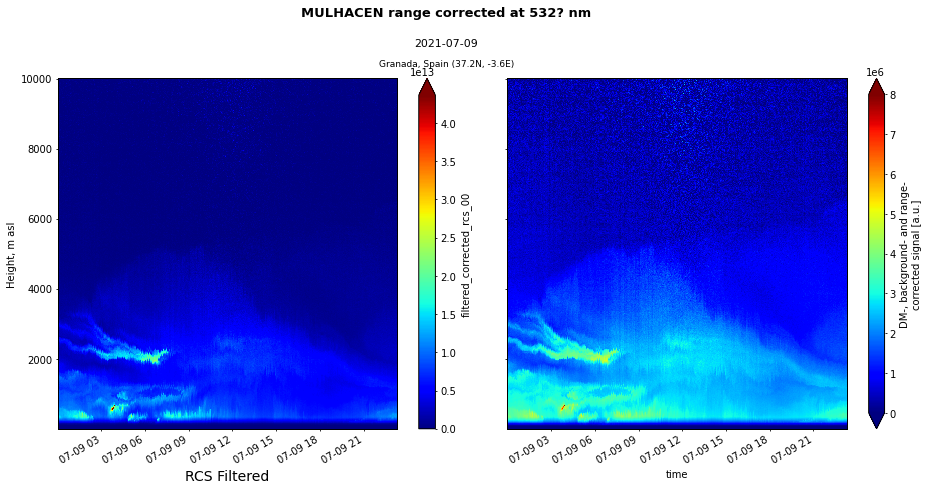

In [167]:
fig, ax = plt.subplots(figsize=[15,7])


plot.title1('{instr} range corrected at {wl}? {wlu}'.format(instr=ds.attrs['system'],
                                                            wl=532,
                                                            wlu='nm'), coef=2)
plot.title2(str(ds.time.values[0].astype('datetime64[D]')), coef=2)

plot.title3('{} ({:.1f}N, {:.1f}E)'.format(ds.attrs['site_location'], 
                                          float(ds.attrs['geospatial_lat_min']), 
                                          float(ds.attrs['geospatial_lon_min'])), coef=2)

# ax1 = plt.subplot(1,6,(1))

# ax1.plot(ds[rcs[0]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='b', label='rcs profile at 532 nm')
# ax1.plot(ds[rcs[1]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='r', label='rcs profile at 1064 nm')
# ax1.legend(fontsize=8)


ax1 = plt.subplot(1,6,(1,3))
p = ds.filtered_corrected_rcs_00[:, ds.filtered_corrected_rcs_00.range<10000].plot.pcolormesh(x='time', 
                y='range', 
                cmap='jet', 
                vmin=0, 
                vmax=ds.filtered_corrected_rcs_00.max()*0.3,
                ax=ax1
                # norm=norm
                )



ax2 = plt.subplot(1,6,(4,15), sharey=ax1)
q = ds.corrected_rcs_00[:, ds.corrected_rcs_00.range<10000].plot.pcolormesh(x='time', 
                y='range', 
                cmap='jet', 
                vmin=0, 
                vmax=8e6,
                ax=ax2
                # norm=norm
                )


# # Create rectangle x coordinates
# startTime = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000')
# endTime = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000') + dt.timedelta(minutes=1)
# start = mpl.dates.date2num(startTime)
# end = mpl.dates.date2num(endTime)
# width = end - start
# rect = mpl.patches.Rectangle((start, 0), width, 10000, linewidth=2,color='red',fill=False)
# ax2.add_patch(rect)

ax2.set_ylabel('')
ax1.set_ylabel('Height, m asl')
ax1.set_xlabel('RCS Filtered', fontsize=14)
# ax1.title('STD of RCS')
# fig.delaxes(ax1)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)

In [ ]:
fl.filtered_corrected_rcs_00[0].values == fl.corrected_rcs_00[0].values


array([False, False, False, ..., False, False, False])

AttributeError: ignored